In [1]:
import pandas as pd
import numpy as np
import warnings
from ProcessPriceData import ProcessPriceData
from Backtester import Backtester
from StatisticalArbitrage import StatisticalArbitrage
from statsmodels.api import OLS
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

warnings.filterwarnings("ignore")

In [2]:
# Reading the data

df = pd.read_excel('HDFC ICICI 2010 D.xlsx')
df.set_index(df['Date'], inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df.dropna(inplace=True)
df  

,HDFCBANK,ICICIBANK
Date,,
2010-01-04 15:30:00,170.57,159.95
2010-01-05 15:30:00,170.72,161.46
2010-01-06 15:30:00,170.84,162.70
2010-01-07 15:30:00,171.28,161.16
2010-01-08 15:30:00,171.51,158.90
...,...,...
2024-03-07 15:30:00,1446.10,1087.95
2024-03-11 15:30:00,1427.80,1078.70
2024-03-12 15:30:00,1459.55,1076.85


In [3]:
df = ProcessPriceData(df)
dfn = df.normalize_prices()
dfn

,HDFCBANK,ICICIBANK
Date,,
2010-01-04 15:30:00,1.000000,1.000000
2010-01-05 15:30:00,1.000879,1.009440
2010-01-06 15:30:00,1.001583,1.017193
2010-01-07 15:30:00,1.004163,1.007565
2010-01-08 15:30:00,1.005511,0.993435
...,...,...
2024-03-07 15:30:00,8.478044,6.801813
2024-03-11 15:30:00,8.370757,6.743982
2024-03-12 15:30:00,8.556897,6.732416


In [4]:
# Initializing Parameters

inst1_n = dfn['HDFCBANK']
inst2_n = dfn['ICICIBANK']
model = 0
date = []
equity = []
look_back = 10
timeperiod = 10
nbdevup, nbdevdn=1.5, 1.5
position = 0
signal = ''
capital = 10000000
sprd = pd.DataFrame(columns = ['Spread', 'Margin'])
qty = []
trade_type = []
entry= []
exit = []
entry_price= []
exit_price = []

In [5]:
# Running the backtest

for i in range(0, len(dfn)):
    
    if i== 0:
        equity.append(capital)
        date.append(dfn.index[i])
        model = OLS([1,1], [1,1])
        model = model.fit()
        
    statarb = StatisticalArbitrage(inst1_n, inst2_n)
        
    val, model = statarb.calculate_hedge_ratio(i, look_back, model)         
    margin = statarb.spread_margin(hedge_ratio = model.params[0])
    
    sprd.loc[len(sprd)] = [val, margin]
    
    if len(sprd) < timeperiod:
        continue
        
    bb = statarb.bollinger_bands_on_spread(sprd, timeperiod, nbdevup, nbdevdn)
    
    # Generating Signals
        
    signal = statarb.bollinger_signals(bb)
        
    # Executing Trades
    
    backtest = Backtester(dfn, prices=bb['Spread'], margins=bb['Margin'])
    
    position, qty, equity, date, trade_type, entry, exit, entry_price, exit_price = backtest.execute_trades(i, capital, signal, position, qty, equity, date, trade_type, entry, exit, entry_price, exit_price)
    

In [6]:
trade_log = backtest.create_trade_log(qty, trade_type, entry, exit, entry_price, exit_price)
trade_log

,Entry Date,Entry Price,Quantity,Exit Date,Exit Price,Trade Type
0,2010-01-29 15:30:00,0.001529,6.499782e+05,2010-02-10 15:30:00,-0.009584,Long
1,2010-02-17 15:30:00,0.008831,6.509630e+05,2010-02-26 15:30:00,0.001766,Short
2,2010-03-03 15:30:00,-0.020344,6.449600e+05,2010-03-15 15:30:00,-0.017302,Long
3,2010-03-18 15:30:00,-0.049692,6.505775e+05,2010-03-29 15:30:00,0.059256,Long
4,2010-04-06 15:30:00,-0.034492,6.493835e+05,2010-04-12 15:30:00,0.016807,Long
...,...,...,...,...,...,...
311,2023-12-21 15:30:00,0.245134,1.843440e+06,2024-01-05 15:30:00,0.408487,Short
312,2024-01-08 15:30:00,-0.056793,1.787878e+06,2024-02-01 15:30:00,-1.098799,Long
313,2024-02-07 15:30:00,-0.146983,1.863029e+06,2024-02-19 15:30:00,-0.402581,Short
314,2024-03-01 15:30:00,-0.421189,1.918578e+06,2024-03-11 15:30:00,-0.056465,Long


In [7]:
accuracy, long_accuracy, short_accuracy = backtest.calculate_accuracy(trade_log)
accuracy, long_accuracy, short_accuracy 

(0.8069620253164557, 0.785234899328859, 0.8263473053892215)

,Strategy
CAGR,0.092000
MAX DD,-0.086000
Sharpe Ratio,0.629513
Sortino Ratio,0.150632
Calmar Ratio,1.100000


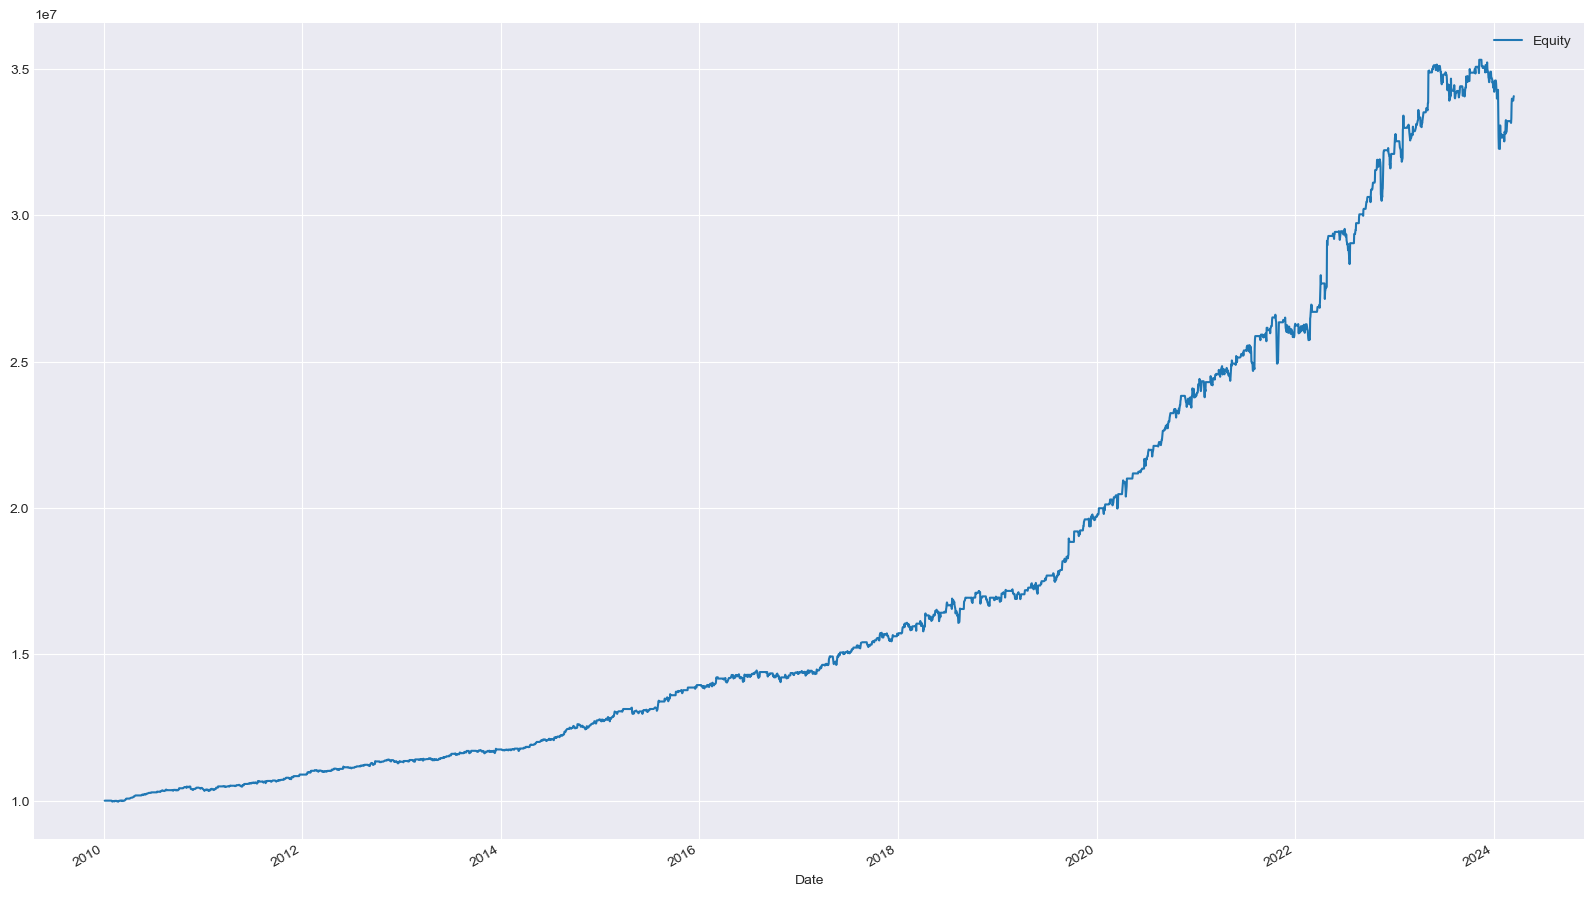

In [8]:
account, results = backtest.calculate_backtest_results(date, equity)
results